# Logistic Regression Classifier - Fitting to all stroke teams together

## Aims

Assess accuracy of a logistic regression classifier, using k-fold (5-fold) training/test data splits (each data point is present in one and only one of the five test sets). This notebook fits all data in a single model, with hospital ID being a one-hot encoded feature.

The notebook includes:

* A range of accuracy scores
* Receiver operating characteristic (ROC) and Sensitivity-Specificity Curves 
* Identify feature weights (model coefficients)
* Performing a learning rate test (relationship between training set size and accuracy)

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

## Import data

Data has previously been split into 5 training/test splits.

In [2]:
data_loc = '../data/kfold_5fold/'

In [3]:
train_data, test_data = [], []

for i in range(5):
    
    train_data.append(pd.read_csv(data_loc + 'train_{0}.csv'.format(i)))
    test_data.append(pd.read_csv(data_loc + 'test_{0}.csv'.format(i)))

## Functions 

### Standardise data

Standardisation subtracts the mean and divides by the standard deviation, for each feature. Here we use the sklearn built-in method for standardisation.

In [4]:
def standardise_data(X_train, X_test):
    """
    Converts all data to a similar scale.
    Standardisation subtracts mean and divides by standard deviation
    for each feature.
    Standardised data will have a mena of 0 and standard deviation of 1.
    The training data mean and standard deviation is used to standardise both
    training and test set data.
    """
    
    # Initialise a new scaling object for normalising input data
    sc = StandardScaler() 

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_std=sc.transform(X_train)
    test_std=sc.transform(X_test)
    
    return train_std, test_std

### Calculate accuracy measures

In [5]:
def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     1) observed positive rate: proportion of observed cases that are +ve
     2) Predicted positive rate: proportion of predicted cases that are +ve
     3) observed negative rate: proportion of observed cases that are -ve
     4) Predicted negative rate: proportion of predicted cases that are -ve  
     5) accuracy: proportion of predicted results that are correct    
     6) precision: proportion of predicted +ve that are correct
     7) recall: proportion of true +ve correctly identified
     8) f1: harmonic mean of precision and recall
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    11) positive likelihood: increased probability of true +ve if test +ve
    12) negative likelihood: reduced probability of true +ve if test -ve
    13) false positive rate: proportion of false +ves in true -ve patients
    14) false negative rate: proportion of false -ves in true +ve patients
    15) true positive rate: Same as recall
    16) true negative rate
    17) positive predictive value: chance of true +ve if test +ve
    18) negative predictive value: chance of true -ve if test -ve
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)
    
    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    false_negatives = (predicted_negatives == 1) & (observed_negatives == 0)
    
    accuracy = np.mean(predicted == observed)
    
    precision = (np.sum(true_positives) /
                 (np.sum(true_positives) + np.sum(false_positives)))
        
    recall = np.sum(true_positives) / np.sum(observed_positives)
    
    sensitivity = recall
    
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    positive_likelihood = sensitivity / (1 - specificity)
    
    negative_likelihood = (1 - sensitivity) / specificity
    
    false_positive_rate = 1 - specificity
    
    false_negative_rate = 1 - sensitivity
    
    true_positive_rate = sensitivity
    
    true_negative_rate = specificity
    
    positive_predictive_value = (np.sum(true_positives) / 
                                 np.sum(observed_positives))
    
    negative_predictive_value = (np.sum(true_negatives) / 
                                  np.sum(observed_negatives))
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['observed_positive_rate'] = np.mean(observed_positives)
    results['observed_negative_rate'] = np.mean(observed_negatives)
    results['predicted_positive_rate'] = np.mean(predicted_positives)
    results['predicted_negative_rate'] = np.mean(predicted_negatives)
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1'] = f1
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predictive_value'] = negative_predictive_value
    
    return results

### Find model probability threshold to match predicted and actual thrombolysis use

In [6]:
def find_threshold(probabilities, true_rate):
    
    """
    Find classification threshold to calibrate model
    """
    
    index = (1-true_rate)*len(probabilities)
    
    threshold = sorted(probabilities)[int(index)]
    
    return threshold

### Line intersect

Used to find point of sensitivity-specificity curve where sensitivity = specificity.

In [7]:
def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

## Fit model (k-fold)

In [8]:
# Set up list to store models and calibarion threshold
single_models = []
thresholds = []

# Set up lists for observed and predicted
observed = []
predicted_proba = []
predicted = []

# Set up list for feature weightsd
feature_weights = []

# Loop through k folds
for k_fold in range(5):
    
    # Get k fold split
    train = train_data[k_fold]
    test = test_data[k_fold]
    
    # Get X and y
    X_train = train.drop('S2Thrombolysis', axis=1)
    X_test = test.drop('S2Thrombolysis', axis=1)
    y_train = train['S2Thrombolysis']
    y_test = test['S2Thrombolysis']
    
    # One hot encode hospitals
    X_train_hosp = pd.get_dummies(X_train['StrokeTeam'], prefix = 'team')
    X_train = pd.concat([X_train, X_train_hosp], axis=1)
    X_train.drop('StrokeTeam', axis=1, inplace=True)
    X_test_hosp = pd.get_dummies(X_test['StrokeTeam'], prefix = 'team')
    X_test = pd.concat([X_test, X_test_hosp], axis=1)
    X_test.drop('StrokeTeam', axis=1, inplace=True)
    
    # Standardise X data
    X_train_std, X_test_std = standardise_data(X_train, X_test)

    # Define and Fit model
    model = LogisticRegression(solver='lbfgs')
    model.fit(X_train_std, y_train)
    
    # Get feature weights
    weights = model.coef_[0]
    feature_weights.append(weights)
    
    # Get predicted probabilities
    y_probs = model.predict_proba(X_test_std)[:,1]
    observed.append(y_test)
    predicted_proba.append(y_probs)
    
    # Calibrate model and get class
    true_rate = np.mean(y_test)
    threshold = find_threshold(y_probs, true_rate)
    thresholds.append(threshold)
    y_class = y_probs >= threshold
    y_class = np.array(y_class) * 1.0
    predicted.append(y_class)
    
    # Print accuracy
    accuracy = np.mean(y_class == y_test)
    print (
        f'Run {k_fold}, accuracy: {accuracy:0.3f}, threshold {threshold:0.3f}')

Run 0, accuracy: 0.833, threshold 0.474
Run 1, accuracy: 0.834, threshold 0.475
Run 2, accuracy: 0.830, threshold 0.469
Run 3, accuracy: 0.833, threshold 0.470
Run 4, accuracy: 0.833, threshold 0.470


## Results 

### Accuracy measures 

In [9]:
# Set up list for results
k_fold_results = []

# Loop through k fold predictions and get accuracy measures
for i in range(5):
    results = calculate_accuracy(observed[i], predicted[i])
    k_fold_results.append(results)
    
# Put results in DataFrame
single_fit_results = pd.DataFrame(k_fold_results).T

In [10]:
single_fit_results

,0,1,2,3,4
observed_positive_rate,0.295232,0.295401,0.295176,0.295080,0.295417
observed_negative_rate,0.704768,0.704599,0.704824,0.704920,0.704583
predicted_positive_rate,0.295232,0.295457,0.295176,0.295080,0.295417
predicted_negative_rate,0.704768,0.704543,0.704824,0.704920,0.704583
accuracy,0.832565,0.833858,0.830316,0.833343,0.833455
precision,0.716435,0.718744,0.712571,0.717607,0.718120
recall,0.716435,0.718881,0.712571,0.717607,0.718120
f1,0.716435,0.718812,0.712571,0.717607,0.718120
sensitivity,0.716435,0.718881,0.712571,0.717607,0.718120
specificity,0.881213,0.882062,0.879627,0.881790,0.881813


In [11]:
single_fit_results.T.describe()

,observed_positive_rate,observed_negative_rate,predicted_positive_rate,predicted_negative_rate,accuracy,precision,recall,f1,sensitivity,specificity,positive_likelihood,negative_likelihood,false_positive_rate,false_negative_rate,true_positive_rate,true_negative_rate,positive_predictive_value,negative_predictive_value
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.295261,0.704739,0.295273,0.704727,0.832707,0.716695,0.716723,0.716709,0.716723,0.881301,6.038613,0.321434,0.118699,0.283277,0.716723,0.881301,0.716723,0.881301
std,0.000146,0.000146,0.000161,0.000161,0.001417,0.002456,0.002485,0.002471,0.002485,0.000986,0.070457,0.003182,0.000986,0.002485,0.002485,0.000986,0.002485,0.000986
min,0.295080,0.704583,0.295080,0.704543,0.830316,0.712571,0.712571,0.712571,0.712571,0.879627,5.919679,0.318707,0.117938,0.281119,0.712571,0.879627,0.712571,0.879627
25%,0.295176,0.704599,0.295176,0.704583,0.832565,0.716435,0.716435,0.716435,0.716435,0.881213,6.031237,0.319660,0.118187,0.281880,0.716435,0.881213,0.716435,0.881213
50%,0.295232,0.704768,0.295232,0.704768,0.833343,0.717607,0.717607,0.717607,0.717607,0.881790,6.070604,0.320250,0.118210,0.282393,0.717607,0.881790,0.717607,0.881790
75%,0.295401,0.704824,0.295417,0.704824,0.833455,0.718120,0.718120,0.718120,0.718120,0.881813,6.076135,0.321790,0.118787,0.283565,0.718120,0.881813,0.718120,0.881813
max,0.295417,0.704920,0.295457,0.704920,0.833858,0.718744,0.718881,0.718812,0.718881,0.882062,6.095409,0.326762,0.120373,0.287429,0.718881,0.882062,0.718881,0.882062


### Receiver Operator Characteristic and Sensitivity-Specificity Curves

Receiver Operator Characteristic Curve:

In [12]:
# Set up lists for results
k_fold_fpr = [] # false positive rate
k_fold_tpr = [] # true positive rate
k_fold_thresholds = [] # threshold applied
k_fold_auc = [] # area under curve

# Loop through k fold predictions and get ROC results 
for i in range(5):
    fpr, tpr, thresholds = roc_curve(observed[i], predicted_proba[i])
    roc_auc = auc(fpr, tpr)
    k_fold_fpr.append(fpr)
    k_fold_tpr.append(tpr)
    k_fold_thresholds.append(thresholds)
    k_fold_auc.append(roc_auc)
    print (f'Run {i} AUC {roc_auc:0.4f}')

# Show mean area under curve  
mean_auc = np.mean(k_fold_auc)
sd_auc = np.std(k_fold_auc)
print (f'\nMean AUC: {mean_auc:0.4f}')
print (f'SD AUC: {sd_auc:0.4f}')

Run 0 AUC 0.9035
Run 1 AUC 0.9056
Run 2 AUC 0.9014
Run 3 AUC 0.9036
Run 4 AUC 0.9045

Mean AUC: 0.9037
SD AUC: 0.0014


Sensitivity-specificity curve:

In [13]:
k_fold_sensitivity = []
k_fold_specificity = []

for i in range(5):
    # Get classificiation probabilities for k-fold replicate
    obs = observed[i]
    proba = predicted_proba[i]
    
    # Set up list for accuracy measures
    sensitivity = []
    specificity = []
    
    # Loop through increments in probability of survival
    thresholds = np.arange(0.0, 1.01, 0.01)
    for cutoff in thresholds: #  loop 0 --> 1 on steps of 0.1
        # Get classificiation using cutoff
        predicted_class = proba >= cutoff
        predicted_class = predicted_class * 1.0
        # Call accuracy measures function
        accuracy = calculate_accuracy(obs, predicted_class)
        # Add accuracy scores to lists
        sensitivity.append(accuracy['sensitivity'])
        specificity.append(accuracy['specificity'])
    
    # Add replicate to lists
    k_fold_sensitivity.append(sensitivity)
    k_fold_specificity.append(specificity)

Combined plot:

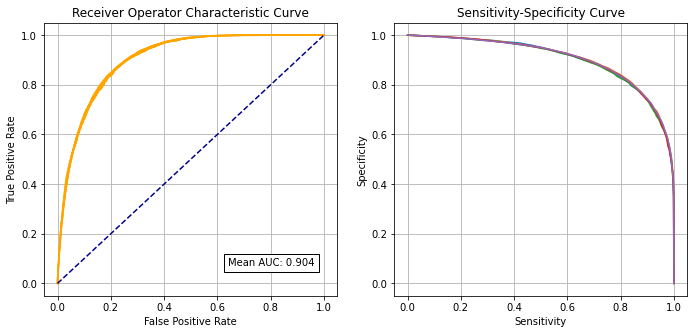

In [14]:
fig = plt.figure(figsize=(10,5))

# Plot ROC
ax1 = fig.add_subplot(121)
for i in range(5):
    ax1.plot(k_fold_fpr[i], k_fold_tpr[i], color='orange')
ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operator Characteristic Curve')
text = f'Mean AUC: {mean_auc:.3f}'
ax1.text(0.64,0.07, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
plt.grid(True)

# Plot sensitivity-specificity
ax2 = fig.add_subplot(122)
for i in range(5):
    ax2.plot(k_fold_sensitivity[i], k_fold_specificity[i])
ax2.set_xlabel('Sensitivity')
ax2.set_ylabel('Specificity')
ax2.set_title('Sensitivity-Specificity Curve')
plt.grid(True)


plt.tight_layout(pad=2)
plt.savefig('./output/lr_single_fit_roc_sens_spec.jpg', dpi=300)

plt.show()

### Identify cross-over of sensitivity and specificity

In [15]:
sens = np.array(k_fold_sensitivity).mean(axis=0)
spec = np.array(k_fold_specificity).mean(axis=0)
df = pd.DataFrame()
df['sensitivity'] = sens
df['specificity'] = spec
df['spec greater sens'] = spec > sens

# find last index for senitivity being greater than specificity 
mask = df['spec greater sens'] == False
last_id_sens_greater_spec = np.max(df[mask].index)
locs = [last_id_sens_greater_spec, last_id_sens_greater_spec + 1]
points = df.iloc[locs][['sensitivity', 'specificity']]

# Get intersetction with line of x=y
a1 = list(points.iloc[0].values)
a2 = list(points.iloc[1].values)
b1 = [0, 0]
b2 = [1, 1]

intersect = get_intersect(a1, a2, b1, b2)[0]
print(f'\nIntersect: {intersect:0.3f}')


Intersect: 0.820


### Collate and save results 

In [16]:
hospital_results = []
kfold_result = []
threshold_results = []
observed_results = []
prob_results = []
predicted_results = []

for i in range(5):
    hospital_results.extend(list(test_data[i]['StrokeTeam']))
    kfold_result.extend(list(np.repeat(i, len(test_data[i]))))
    threshold_results.extend(list(np.repeat(thresholds[i], len(test_data[i]))))
    observed_results.extend(list(observed[i]))
    prob_results.extend(list(predicted_proba[i]))
    predicted_results.extend(list(predicted[i]))    
    
single_model = pd.DataFrame()
single_model['hospital'] = hospital_results
single_model['observed'] = np.array(observed_results) * 1.0
single_model['prob'] = prob_results
single_model['predicted'] = predicted_results
single_model['k_fold'] = kfold_result
single_model['threshold'] = threshold_results
single_model['correct'] = single_model['observed'] == single_model['predicted']

# Save
filename = './predictions/single_fit_rf_k_fold.csv'
single_model.to_csv(filename, index=False)

## Feature Weights

Get Logistic Regression weights (average across k-fold results).
Sort by absolute value of weight.

In [17]:
features = X_test.columns.values

# Get average feature importance from k-fold
weights = np.array(feature_weights).mean(axis = 0)
weights = pd.DataFrame(data = weights, index=features)
weights.columns = ['weight']
weights['abs_weight'] = abs(weights['weight'])

# Sort by importance (weight)
weights.sort_values(by='abs_weight', ascending=False, inplace=True)

# Save
weights.to_csv('output/lr_single_fit_feature_weights.csv')

# Display top 25
weights.head(25)

,weight,abs_weight
S2BrainImagingTime_min,-18.492408,18.492408
S2StrokeType_Infarction,2.017887,2.017887
S2StrokeType_Primary Intracerebral Haemorrhage,-2.009112,2.009112
S2RankinBeforeStroke,-0.496542,0.496542
AFAnticoagulent_Yes,-0.386646,0.386646
Loc,-0.376646,0.376646
BestLanguage,0.307656,0.307656
S1OnsetDateType_Stroke during sleep,-0.300494,0.300494
S1OnsetTimeType_Best estimate,-0.289682,0.289682
S1OnsetTimeType_Precise,0.289682,0.289682


Line chart:

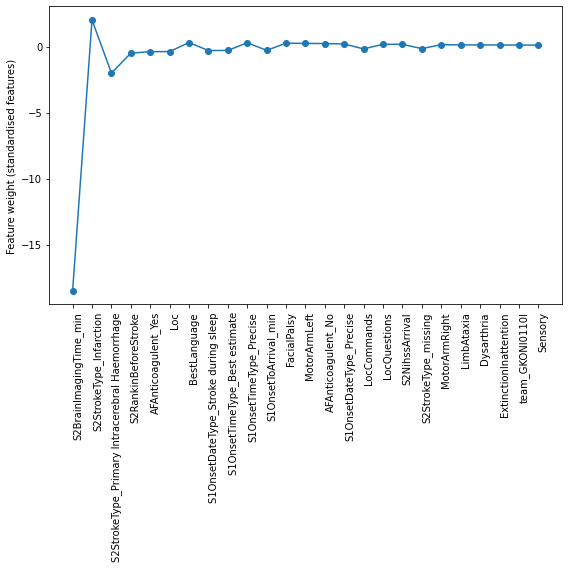

In [18]:
# Set up figure
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

# Get labels and values
labels = weights.index.values[0:25]
val = weights['weight'].values[0:25]

# Plot
ax.plot(val, marker='o')
ax.set_ylabel('Feature weight (standardised features)')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

plt.tight_layout()
plt.savefig('output/lr_single_fit_feature_weights_line.jpg', dpi=300)
plt.show()

Bar chart:

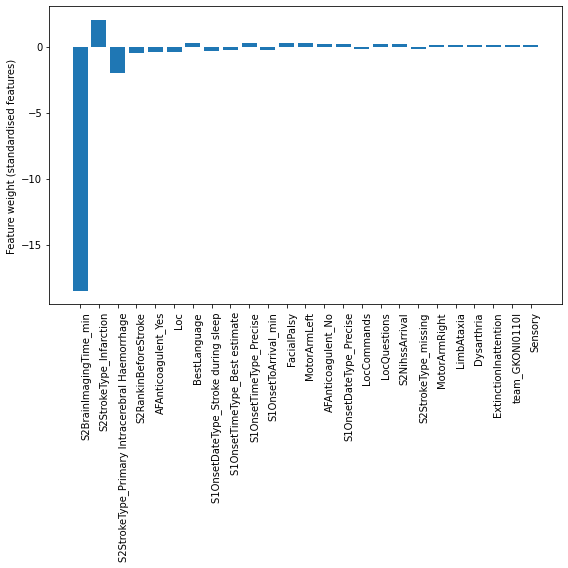

In [19]:
# Set up figure
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

# Get labels and values
labels = weights.index.values[0:25]
pos = np.arange(len(labels))
val = weights['weight'].values[0:25]

# Plot
ax.bar(pos, val)
ax.set_ylabel('Feature weight (standardised features)')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

plt.tight_layout()
plt.savefig('output/lr_single_fit_feature_weights_bar.jpg', dpi=300)
plt.show()

## Learning cvurve

Examine the relationship between training data size and accuracy.

In [20]:
# Set up list to collect results
results_training_size = []
results_accuracy = []
results_all_accuracy = []

# Get maximum training size (number of training records)
max_training_size = train_data[0].shape[0]

# Construct training sizes (values closer at lower end)
train_sizes = [50, 100, 250, 500, 1000, 2500]
for i in range (5000, max_training_size, 5000):
    train_sizes.append(i)

# Loop through training sizes
for train_size in train_sizes:
    
    # Record accuracy across k-fold replicates
    replicate_accuracy = []

    for replicate in range(5):
        
        # Get training and test data (from first k-fold split)
        train = train_data[0]
        test = test_data[0]
        
        # One hot encode hospitals
        train_hosp = pd.get_dummies(train['StrokeTeam'], prefix = 'team')
        train = pd.concat([train, train_hosp], axis=1)
        train.drop('StrokeTeam', axis=1, inplace=True)
        test_hosp = pd.get_dummies(test['StrokeTeam'], prefix = 'team')
        test = pd.concat([test, test_hosp], axis=1)
        test.drop('StrokeTeam', axis=1, inplace=True) 
        
        # Sample from training data
        train = train.sample(n=train_size)

        # Get X and y
        X_train = train.drop('S2Thrombolysis', axis=1)
        X_test = test.drop('S2Thrombolysis', axis=1)
        y_train = train['S2Thrombolysis']
        y_test = test['S2Thrombolysis']        
   
        # Standardise X data
        X_train_std, X_test_std = standardise_data(X_train, X_test)

        # Define and Fit model
        model = LogisticRegression(solver='lbfgs')
        model.fit(X_train_std, y_train)

        # Predict test set
        y_pred_test = model.predict(X_test_std)

        # Get accuracy and record results
        accuracy = np.mean(y_pred_test == y_test)
        replicate_accuracy.append(accuracy)
        results_all_accuracy.append(accuracy)
    
    # Store mean accuracy across the k-fold splits
    results_accuracy.append(np.mean(replicate_accuracy))
    results_training_size.append(train_size)
    
k_fold_accuracy = np.array(results_all_accuracy).reshape(len(train_sizes), 5)

Plot learning curve

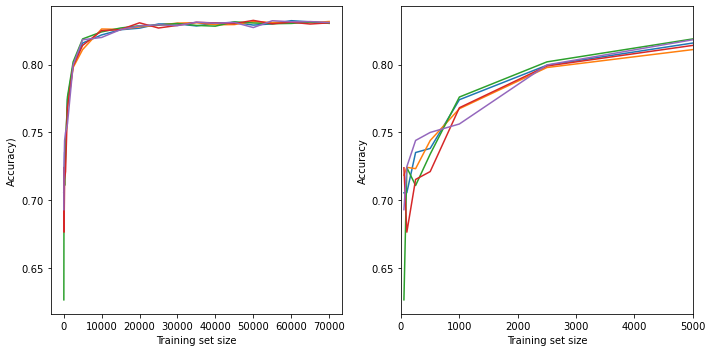

In [21]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)

for i in range(5):
    ax1.plot(results_training_size, k_fold_accuracy[:, i])

ax1.set_xlabel('Training set size')
ax1.set_ylabel('Accuracy)')

# Focus on first 5000
ax2 = fig.add_subplot(122)
for i in range(5):
    ax2.plot(results_training_size, k_fold_accuracy[:, i])

ax2.set_xlabel('Training set size')
ax2.set_ylabel('Accuracy')
ax2.set_xlim(0, 5000)

plt.tight_layout()
plt.savefig('./output/lr_single_learning_curve.jpg', dpi=300)
plt.show()

## Calibration and assessment of accuracy when model has high confidence

In [22]:
# Collate results in Dataframe
reliability_collated = pd.DataFrame()

# Loop through k fold predictions
for i in range(5):
    
    # Get observed class and predicted probability
    obs = observed[i]
    prob = predicted_proba[i]
    
    # Bin data with numpy digitize (this will assign a bin to each case)
    step = 0.10
    bins = np.arange(step, 1+step, step)
    digitized = np.digitize(prob, bins)
        
    # Put single fold data in DataFrame
    reliability = pd.DataFrame()
    reliability['bin'] = digitized
    reliability['probability'] = prob
    reliability['observed'] = obs
    classification = 1 * (prob > 0.5 )
    reliability['correct'] = obs == classification
    reliability['count'] = 1
    
    # Summarise data by bin in new dataframe
    reliability_summary = pd.DataFrame()

    # Add bins and k-fold to summary
    reliability_summary['bin'] = bins
    reliability_summary['k-fold'] = i

    # Calculate mean of predicted probability of thrombolysis in each bin
    reliability_summary['confidence'] = \
        reliability.groupby('bin').mean()['probability']

    # Calculate the proportion of patients who receive thrombolysis
    reliability_summary['fraction_positive'] = \
        reliability.groupby('bin').mean()['observed']
    
    # Calculate proportion correct in each bin
    reliability_summary['fraction_correct'] = \
        reliability.groupby('bin').mean()['correct']
    
    # Calculate fraction of results in each bin
    reliability_summary['fraction_results'] = \
        reliability.groupby('bin').sum()['count'] / reliability.shape[0]   
    
    # Add k-fold results to DatafRame collation
    reliability_collated = reliability_collated.append(reliability_summary)
    
# Get mean results
reliability_summary = reliability_collated.groupby('bin').mean()
reliability_summary.drop('k-fold', axis=1, inplace=True)

In [23]:
reliability_summary

,confidence,fraction_positive,fraction_correct,fraction_results
bin,,,,
0.1,0.019171,0.016898,0.983102,0.413334
0.2,0.147242,0.141325,0.858675,0.096426
0.3,0.248821,0.238344,0.761656,0.076781
0.4,0.349045,0.341080,0.658920,0.071136
0.5,0.450110,0.453552,0.546448,0.066065
0.6,0.549273,0.566846,0.566846,0.064974
0.7,0.650030,0.666892,0.666892,0.062151
0.8,0.749249,0.781425,0.781425,0.059700
0.9,0.849119,0.846543,0.846543,0.057282


Plot results:

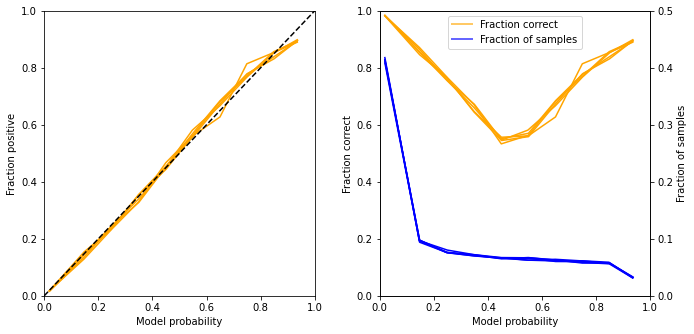

In [24]:
fig = plt.figure(figsize=(10,5))


# Plot predicted prob vs fraction psotive
ax1 = fig.add_subplot(1,2,1)

# Loop through k-fold reliability results
for i in range(5):
    mask = reliability_collated['k-fold'] == i
    k_fold_result = reliability_collated[mask]
    x = k_fold_result['confidence']
    y = k_fold_result['fraction_positive']
    ax1.plot(x,y, color='orange')
# Add 1:1 line
ax1.plot([0,1],[0,1], color='k', linestyle ='--')
# Refine plot
ax1.set_xlabel('Model probability')
ax1.set_ylabel('Fraction positive')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

# Plot accuracy vs probability
ax2 = fig.add_subplot(1,2,2)
# Loop through k-fold reliability results
for i in range(5):
    mask = reliability_collated['k-fold'] == i
    k_fold_result = reliability_collated[mask]
    x = k_fold_result['confidence']
    y = k_fold_result['fraction_correct']
    ax2.plot(x,y, color='orange')
# Refine plot
ax2.set_xlabel('Model probability')
ax2.set_ylabel('Fraction correct')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)

ax3 = ax2.twinx()  # instantiate a second axes that shares the same x-axis
for i in range(5):
    mask = reliability_collated['k-fold'] == i
    k_fold_result = reliability_collated[mask]
    x = k_fold_result['confidence']
    y = k_fold_result['fraction_results']
    ax3.plot(x,y, color='blue')
    
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 0.5)
ax3.set_ylabel('Fraction of samples')

custom_lines = [Line2D([0], [0], color='orange', alpha=0.6, lw=2),
                Line2D([0], [0], color='blue', alpha = 0.6,lw=2)]

plt.legend(custom_lines, ['Fraction correct', 'Fraction of samples'],
          loc='upper center')

plt.tight_layout(pad=2)
plt.savefig('./output/lr_single_reliability.jpg', dpi=300)
plt.show()

Get accuracy of model when model is at least 80% confident

In [25]:
bins = [0.1, 0.2, 0.9, 1.0]
acc = reliability_summary.loc[bins].mean()['fraction_correct']
frac = reliability_summary.loc[bins].sum()['fraction_results']

print ('For samples with at least 80% confidence:')
print (f'Proportion of all samples: {frac:0.3f}')
print (f'Accuracy: {acc:0.3f}')

For samples with at least 80% confidence:
Proportion of all samples: 0.599
Accuracy: 0.896


## Observations

* Overall accuracy = 83.2% (89.6% for those 60% samples with at least 80% confidence of model)
* Using nominal threshold (50% probability), specificity (88%) is greater than sensitivity (72%)
* The model can achieve 82.0% sensitivity and specificity simultaneously
* ROC AUC = 0.904
* Only marginal improvements are made above a training set size of 20k
* Key features predicting use of thrombolysis are:
    * Time from arrival to scan
    * Stroke type
    * Disability before stroke
    * Presence of AFAnticoagulent_Yes
    * Level of consciousness
* The model shows good calibration of probability vs. fraction positive, without need of additional calibration